In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [3]:
# Load the data from the CSV file

output_directory = './img/'
df = pd.read_csv('output.csv')
df['Iteration'] = df['InputFileName'].str.extract(r'(\d+)-')

# Monolithic vs Microservices Experiment

Calculating joules

$E=P.\Delta t$

`Joules = Watts * Time in Seconds`

# Todo
- Analyse Average Watts per iteration ✅
- Calculate Joules per iteration ✅
- Analyse Energy Consumption in Joules per Iteration ✅
- Break down Energy Consumption by Frontend and Backend
- Analyse Temperature per Iteration and compare to Energy Consumption
- Analyse C State per iteration



In [4]:
# Calculate the Joules for each file name
time_column = ''

for file_name in df['InputFileName'].unique():
    subset = df[df['InputFileName'] == file_name]

    # Sum the watts for the current file name
    # total_watts = subset['Watts'].sum()
    average_watts = subset['Watts'].mean()
    average_cpu = subset['CPU'].mean()
    average_temp = subset['TMEM'].mean()

    # Determine the relevant time column based on the file name
    if 'frontend' in file_name.lower():
        if subset['Architecture'].iloc[0] == 'mono':
            time_column = 'MonoFrontendDuration'
        else:
            time_column = 'MicroFrontendDuration'

    elif 'backend' in file_name.lower():
        if subset['Architecture'].iloc[0] == 'mono':
            time_column = 'MonoBackendDuration'
        else:
            time_column = 'MicroBackendDuration'

    # Calculate Joules for the current file name
    # Average of all those watt values * 60 seconds
    df.loc[df['InputFileName'] == file_name, 'Average_Watts'] = average_watts
    df.loc[df['InputFileName'] == file_name, 'Average_CPU'] = average_cpu
    df.loc[df['InputFileName'] == file_name, 'Average_Temperature'] = average_temp
    df.loc[df['InputFileName'] == file_name, 'Joules'] = average_watts * subset[time_column]
    

In [ ]:
def plot_baseline_scenario(df, scenarios, y_column='Joules', y_lim=None, aggregation='mean'):
    plt.figure(figsize=(10, 6))

    df['Iteration'] = df['Iteration'].astype(int)  # Convert 'Iteration' column to integers

    for scenario in scenarios:
        df_scenario = df[(df['ScenarioPath'] == scenario) & (df['Iteration'].between(1, 30))]
        if aggregation == 'mean':
            df_grouped = df_scenario.groupby('Iteration')[y_column].mean().reset_index()
        elif aggregation == 'sum':
            df_grouped = df_scenario.groupby('Iteration')[y_column].sum().reset_index()

        plt.plot(df_grouped['Iteration'], df_grouped[y_column], label=f'Scenario {scenario}')

    plt.xlabel('Iteration')
    plt.ylabel(y_column)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.title(f'{y_column} over Iterations')
    plt.show()  # Display the plot

plot_baseline_scenario(df, [1, 2], y_column='Joules', y_lim=None, aggregation='mean')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/4019029880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split['Iteration'] = df_split['InputFileName'].str.extract('(\d+)').astype(int)
/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/4019029880.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split['Iteration'] = df_split['InputFileName'].str.extract('(\d+)').astype(int)


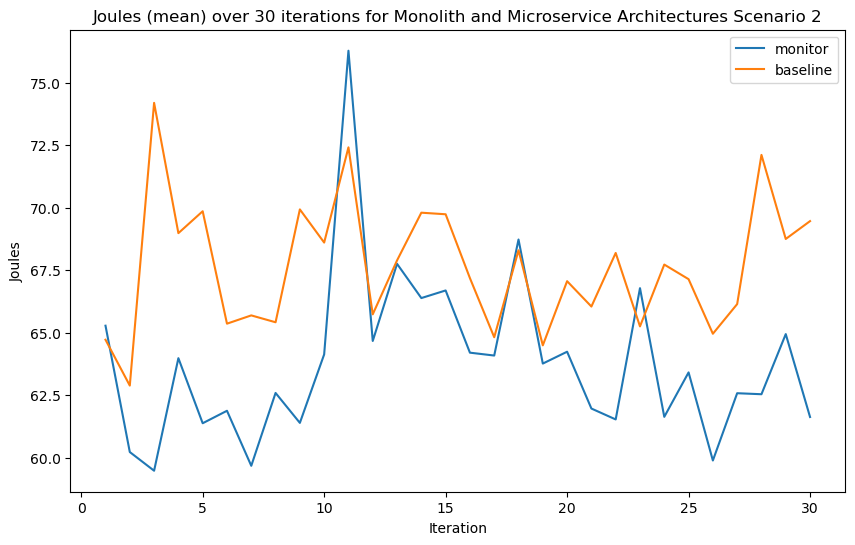

In [31]:
def plot_baseline_scenario(df, scenario, output_directory, y_column='Joules', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]
    # filter df
    df_copy = df_copy[df_copy['Architecture'] == "mono"]

    # Split the DataFrame based on 'InputFileName'
    df_monitor = df_copy[df_copy['InputFileName'].str.contains('monitor')]
    df_baseline = df_copy[df_copy['InputFileName'].str.contains('baseline')]

    plt.figure(figsize=(10, 6))

    for df_split, split_name in [(df_monitor, 'monitor'), (df_baseline, 'baseline')]:
        # Step 1: Extract iteration number
        df_split['Iteration'] = df_split['InputFileName'].str.extract('(\d+)').astype(int)

        # Step 2: Group by 'Iteration' and 'Architecture' and calculate mean or sum of 'Average_Watts'
        if aggregation == 'mean':
            grouped_df = df_split.groupby(['Iteration', 'Architecture'])[y_column].mean()
        elif aggregation == 'sum':
            grouped_df = df_split.groupby(['Iteration', 'Architecture'])[y_column].sum()
        else:
            raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

        # Step 3: Reset index
        grouped_df = grouped_df.reset_index()

        # Step 4: Create line plot
        sns.lineplot(data=grouped_df, x='Iteration', y=y_column, label=split_name)

    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures Scenario {scenario}')
    title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}.png'
    if y_lim:
        plt.ylim(0, y_lim)
        title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}_ylim_{y_lim}.png'

    plt.savefig(os.path.join(output_directory, title), bbox_inches='tight', dpi=300)
    plt.show()

plot_baseline_scenario(df, 2, output_directory, y_column='Joules', y_lim=None, aggregation='mean')

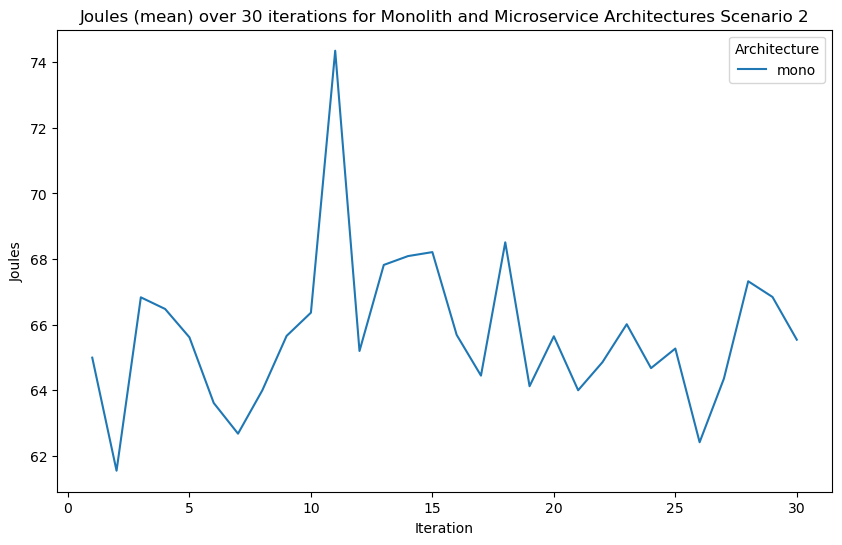

In [6]:
def plot_scenario(df, scenario, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]
    df_copy = df_copy[df_copy['Architecture'] == "mono"]

    # Step 1: Extract iteration number
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)

    # Step 2: Group by 'Iteration' and 'Architecture' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures Scenario {scenario}')

    title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}.png'
    if y_lim:
        plt.ylim(0, y_lim)
        title = f'{y_column.lower()}_scenario_{scenario}_{aggregation}_ylim_{y_lim}.png'

    plt.savefig(os.path.join(output_directory, title), bbox_inches='tight', dpi=300)
    plt.show()

plot_scenario(df, 2, output_directory, y_column='Joules', y_lim=None, aggregation='mean')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/2387298683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


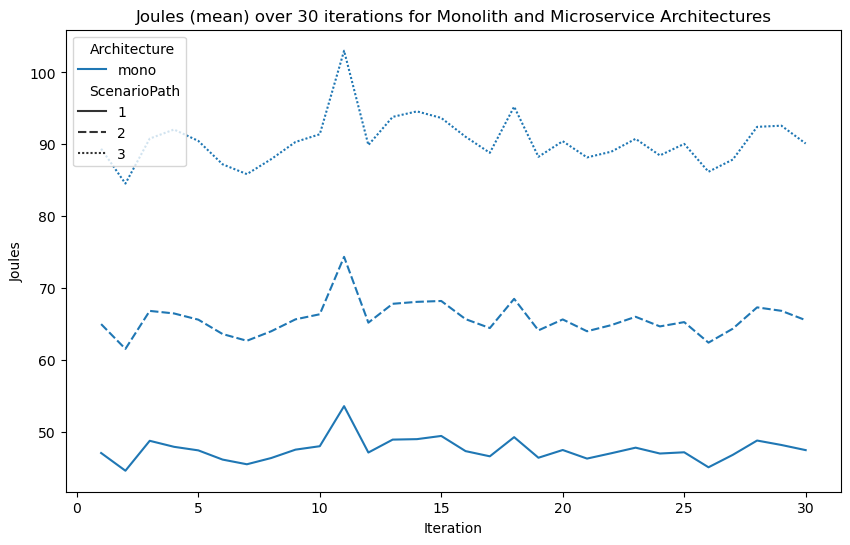

In [7]:
def plot_all_scenarios(df, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean', y_start=0):
    # Step 1: Extract iteration number
    
    df_copy = df[df['Architecture'] == "mono"]
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


    # Step 2: Group by 'Iteration', 'Architecture', and 'ScenarioPath' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'ScenarioPath'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture', style='ScenarioPath')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for Monolith and Microservice Architectures')

    if y_lim:
        plt.ylim(y_start, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_all_scenarios_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

plot_all_scenarios(df, output_directory, y_column='Joules', y_lim=None, aggregation='mean', y_start=0)

In [8]:
def plot_architecture_types(df, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    # Step 1: Extract iteration number and architecture type
    df['Iteration'] = df['InputFileName'].str.extract('(\d+)').astype(int)
    df['Type'] = df['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Iteration', 'Architecture', and 'Type' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'Type'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df.groupby(['Iteration', 'Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Architecture', style='Type')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for different architecture types')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [9]:
def plot_architecture_types_for_scenario(df, scenario, output_directory, y_column='Average_Watts', y_lim=None, aggregation='mean'):
    df_copy = df[df['ScenarioPath'] == scenario]

    # Step 1: Extract iteration number and architecture type
    df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)
    df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Iteration', 'Architecture', and 'Type' and calculate mean or sum of 'Average_Watts'
    if aggregation == 'mean':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'Type'])[y_column].mean()
    elif aggregation == 'sum':
        grouped_df = df_copy.groupby(['Iteration', 'Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose either 'mean' or 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=grouped_df, x='Iteration', y=y_column, hue='Type', style='Architecture')
    plt.title(f'{y_column.replace("_", " ")} ({aggregation}) over 30 iterations for different architecture types in Scenario {scenario}')

    if y_lim:
        plt.ylim(0, y_lim)

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_scenario_{scenario}_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [10]:
def plot_joules_for_scenario(df, scenario, output_directory, y_column='Joules', aggregation='sum'):
    df_copy = df[df['ScenarioPath'] == scenario]

    # Step 1: Extract architecture type
    df_copy['Type'] = df_copy['InputFileName'].str.extract('-(\w+-\w+)\.csv')

    # Step 2: Group by 'Architecture' and 'Type' and calculate sum of 'Joules'
    if aggregation == 'sum':
        grouped_df = df_copy.groupby(['Architecture', 'Type'])[y_column].sum()
    else:
        raise ValueError("Invalid aggregation method. Choose 'sum'.")

    # Step 3: Reset index
    grouped_df = grouped_df.reset_index()

    # Step 4: Create bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped_df, x='Type', y=y_column, hue='Architecture')
    plt.title(f'Total {y_column} for different architecture types in Scenario {scenario}')

    plt.savefig(os.path.join(output_directory, f'{y_column.lower()}_architecture_types_scenario_{scenario}_{aggregation}.png'), bbox_inches='tight', dpi=300)
    plt.show()

In [11]:
# Call the function for each scenario
# for scenario in range(1, 4):
    # plot_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='mean')
    # plot_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='sum')
    # plot_architecture_types_for_scenario(df, scenario, output_directory, 'Average_Watts', aggregation='sum')
    
# plot_architecture_types(df, output_directory, 'Average_Watts', aggregation='mean')

# plot_all_scenarios(df, output_directory, 'Average_Watts', aggregation='mean')
# plot_all_scenarios(df, output_directory, 'Average_Watts', aggregation='sum')


/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/2387298683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


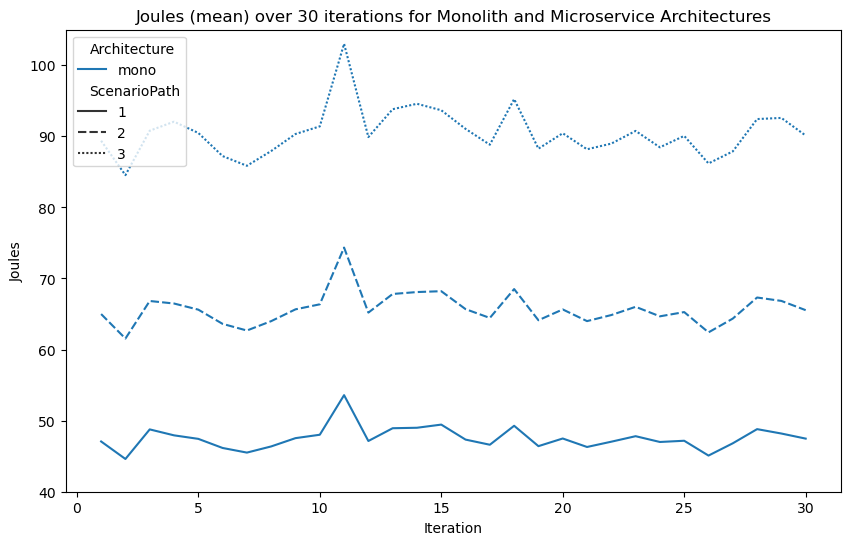

In [12]:
# Call the function for each scenario
# for scenario in range(1, 4):
    # plot_scenario(df, scenario, output_directory, 'Joules', aggregation='mean')
    # plot_scenario(df, scenario, output_directory, 'Joules', aggregation='sum')

plot_all_scenarios(df, output_directory, 'Joules', aggregation='mean', y_lim=105, y_start=40)
# plot_all_scenarios(df, output_directory, 'Joules', aggregation='sum')

# plot_joules_for_scenario(df, 1, output_directory, aggregation='sum')

# y_column = 'Joules'
#     # Group by 'Iteration' and 'ScenarioPath' and calculate mean of 'Average_Watts'
# # Group by 'Iteration' and 'ScenarioPath' and calculate mean of y_column
# grouped_df = df.groupby(['Iteration', 'ScenarioPath'])[y_column].mean()

# # Convert the Series to a DataFrame and reset the index
# table_df = grouped_df.reset_index()

# # Rename the columns
# table_df.columns = ['Iteration', 'ScenarioPath', 'Average Joules']

# # Display the table
# print(table_df)
# table_df.to_csv('output.csv', index=False)

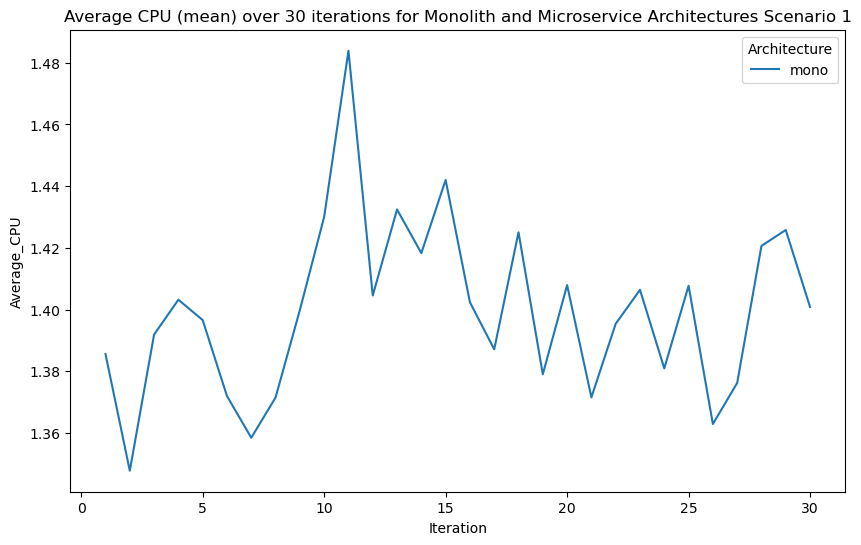

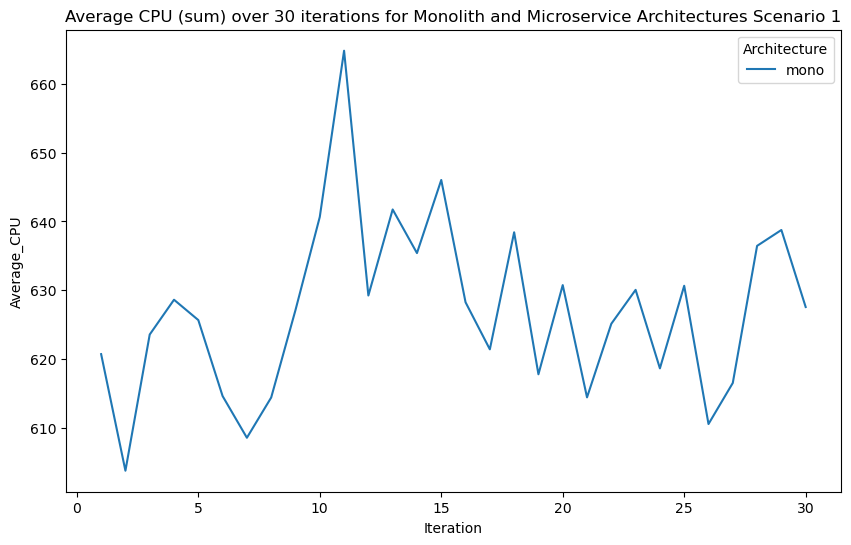

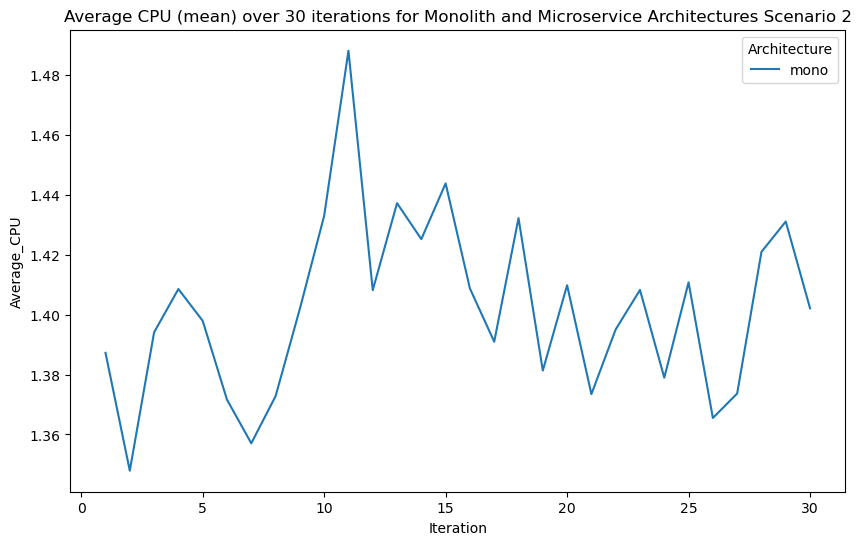

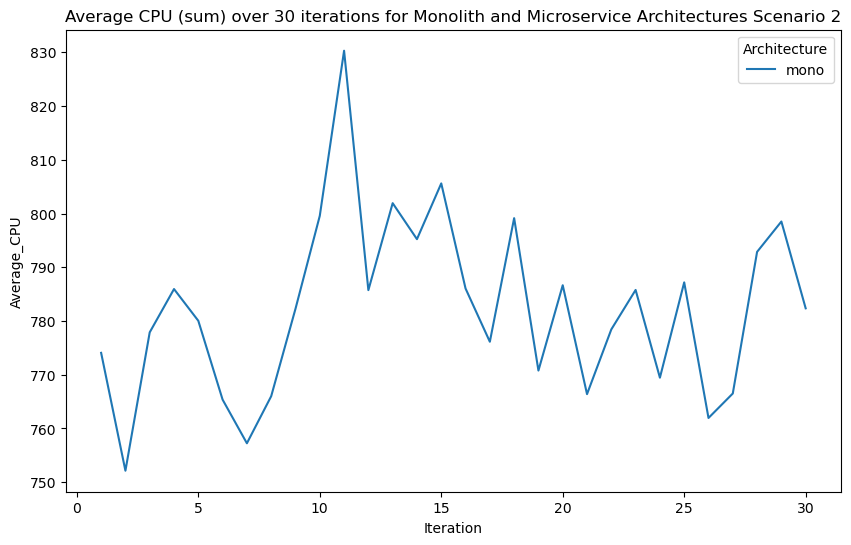

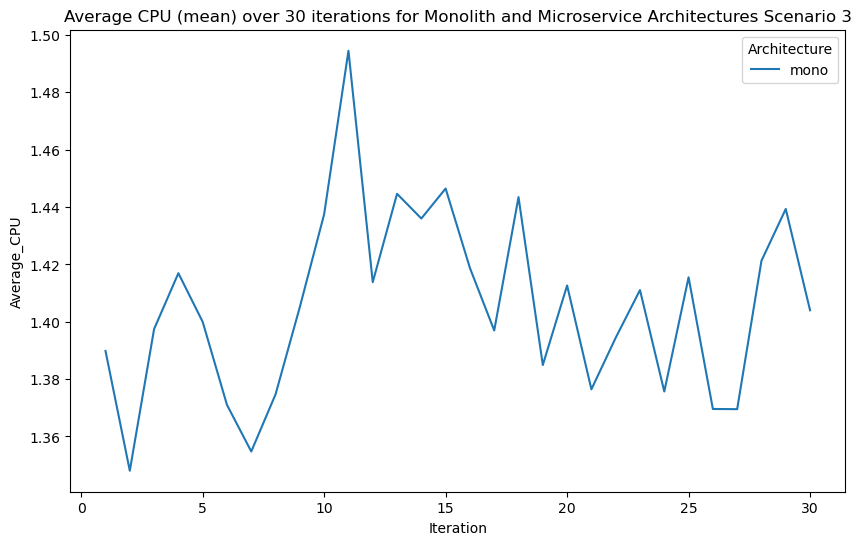

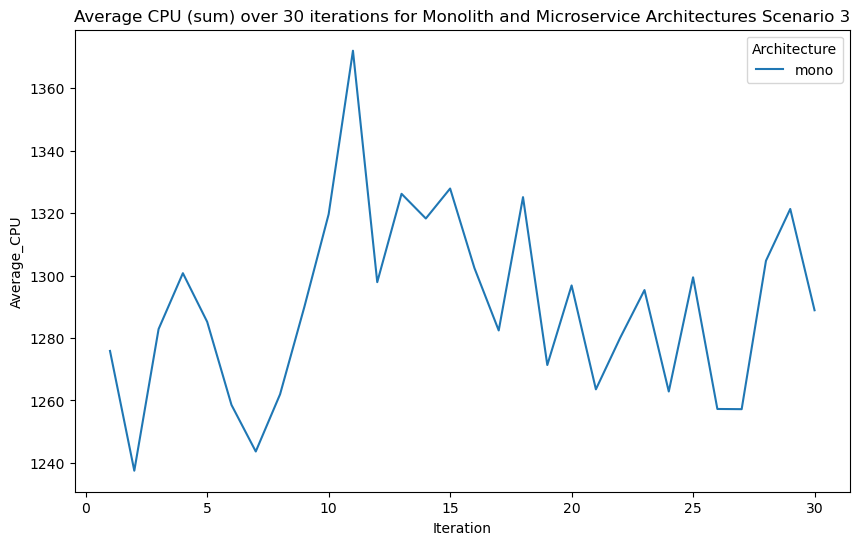

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/2387298683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


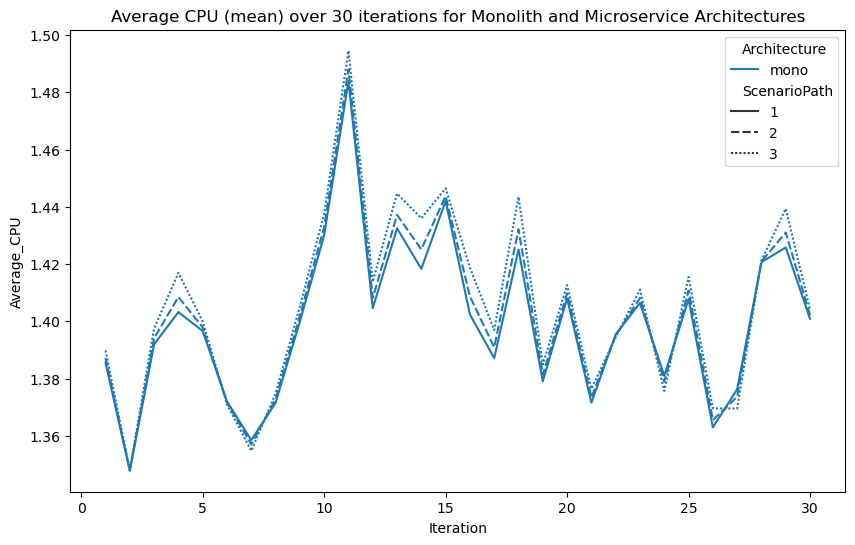

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/2387298683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


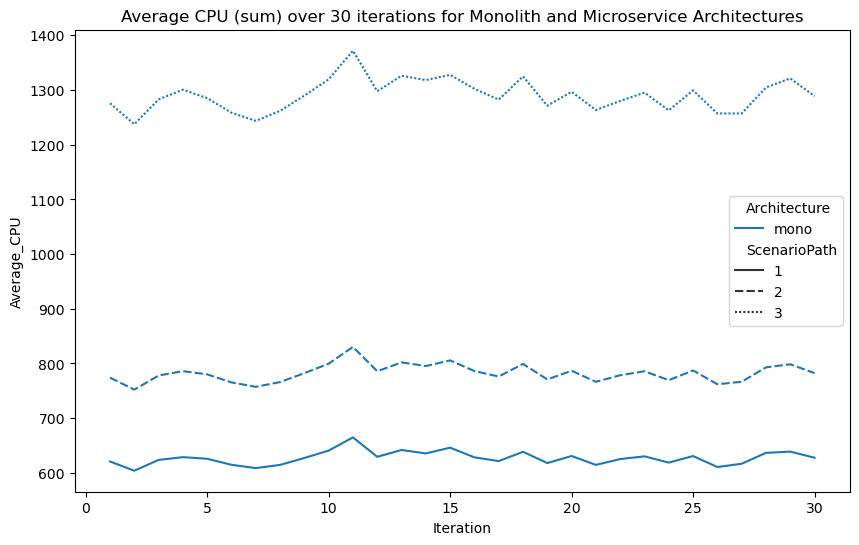

In [13]:
# Call the function for each scenario
for scenario in range(1, 4):
    plot_scenario(df, scenario, output_directory, 'Average_CPU', aggregation='mean')
    plot_scenario(df, scenario, output_directory, 'Average_CPU', aggregation='sum')

plot_all_scenarios(df, output_directory, 'Average_CPU', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Average_CPU', aggregation='sum')

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/2387298683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


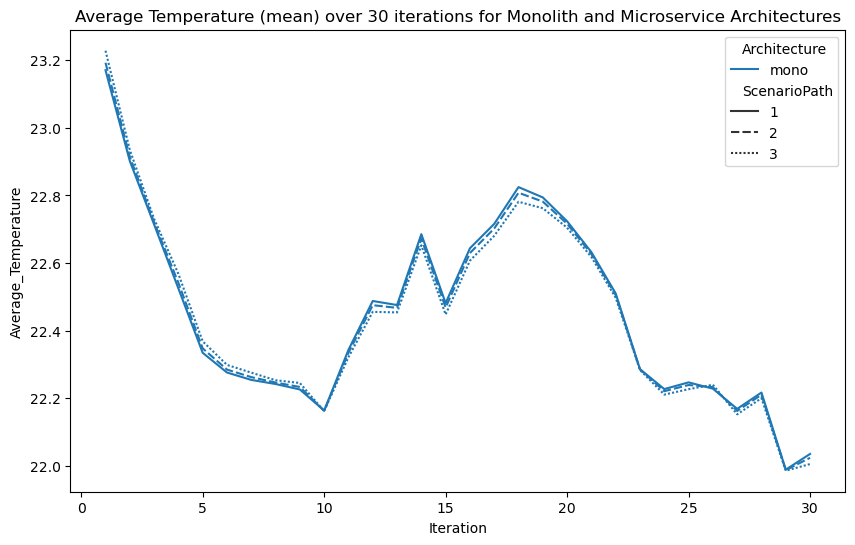

/var/folders/w4/j0dx067d6_v_bwmcgq6v985r0000gn/T/ipykernel_54235/2387298683.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Iteration'] = df_copy['InputFileName'].str.extract('(\d+)').astype(int)


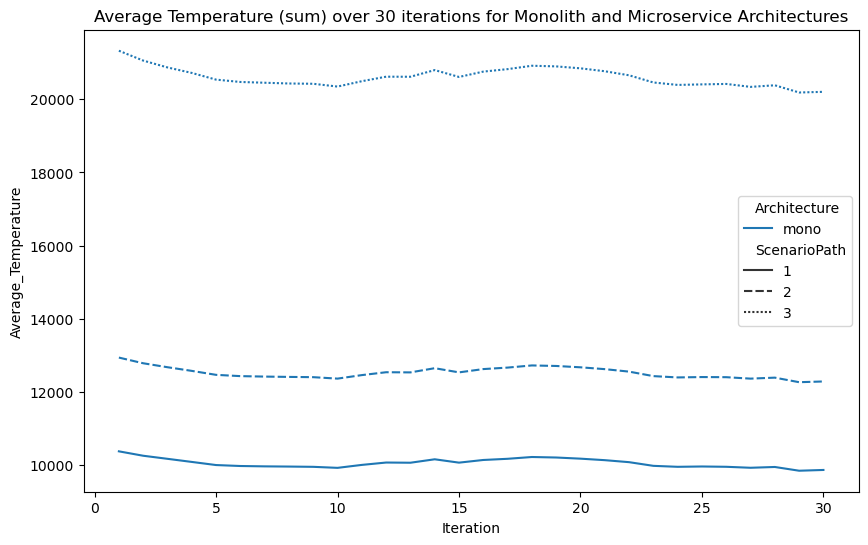

In [14]:
plot_all_scenarios(df, output_directory, 'Average_Temperature', aggregation='mean')
plot_all_scenarios(df, output_directory, 'Average_Temperature', aggregation='sum')